# 05/19/23 - Copied from 012523_jam_bayes.ipynb. Testing the new implementation of anisotropy profiles from Michele. See https://mail.google.com/mail/u/0/?tab=rm&ogbl#search/osipkov/FMfcgzGrcFfBKDBKxwlvtkWlVRXdvklX
# 05/22/23 - Corrected the "details_for_jampy.pkl" - ONLY FOR J0037 SN 15 so far
- surface brightness is now correctly computed from B-mag (I think)
- bin x and y coordinates rotated along the photometric axis are now correct (phot maj axis is x axis)
# 05/25/23 - Starting a new notebook just to keep things cleaner.

In [2]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
import pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_radial_mass import mge_radial_mass
from plotbin.symmetrize_velfield import symmetrize_velfield

# adamet
from adamet.adamet import adamet
from adamet.corner_plot import corner_plot

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_ani_mass_jam import osipkov_merritt_model
from slacs_ani_mass_jam import osipkov_merritt_generalized_model
from slacs_ani_mass_jam import inner_outer_anisotropy_model
from slacs_ani_mass_jam import nfw_generalized_model
from slacs_ani_mass_jam import dark_halo_mge
from slacs_ani_mass_jam import total_mass_mge
from slacs_ani_mass_jam import jam_lnprob
from slacs_ani_mass_jam import jam_lnprob_power_law
from slacs_ani_mass_jam import jam_lnprob_nfw_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfwgen_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfw_om
from slacs_ani_mass_jam import jam_lnprob_nfwgen_om
from slacs_ani_mass_jam import summary_plot
from slacs_ani_mass_jam import save_fit_parameters
from slacs_ani_mass_jam import get_power_law_slope
from slacs_ani_mass_jam import jampy_details
from slacs_ani_mass_jam import prepare_to_jam
from slacs_ani_mass_jam import space_jam
from slacs_mge_jampy import make_gaussian

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
#extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
#photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
#z = 0.195
#distance = cosmo.angular_diameter_distance(z).value

In [3]:
##################################################################################################################################

date_of_kin = '2023-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_051223.csv')
zs = paper_table['zlens']

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/



In [4]:
# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapsf 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff

______________________

# Dynamical Modeling with JAM

## See how the beta has changed

# Let's make the function work for all the different variations we want.

In [5]:
def prepare_to_jam(obj_name, file_dir, SN):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)

    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
    Vrms_bin = tommy_pickles.Vrms_bin
    dVrms_bin = tommy_pickles.dVrms_bin # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)

In [147]:
def summary_plot(obj_name, date_time, model_dir, jam_prob_func, pars=None, lnprob=None, labels=None, bounds=None, kwargs=None, save=False, load=False):
    
    """
    Print the best fitting solution with uncertainties.
    Plot the final corner plot with the best fitting JAM model.

    """
    
    xbin = kwargs['xbin']
    ybin = kwargs['ybin']
    goodbins = kwargs['goodbins']
    rms = kwargs['rms']
    
    if load == True:
        jam_test_dir = model_dir #f'{data_dir}jam_testing/2023_01_31/'
        pars = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*parameters_fit.txt')[0])
        lnprob = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*likelihood.txt')[0])
        labels = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*labels.txt')[0], delimiter='  ', dtype='<U20')
        bounds = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bounds.txt')[0])
        bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters.txt')[0])
        perc = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_percentile.txt')[0])
        sig_bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_error.txt')[0])
        surf_potential = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*surf_potential.txt')[0])
        rms_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*rms_model.txt')[0])
        flux_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*flux_model.txt')[0])
    
    else:
        
        bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
        perc = np.percentile(pars, [15.86, 84.14], axis=0)  # 68% interval
        sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
        
        # save variables, surf_pot, sigma_pot, qobs_pot, rms_model and flux_model
        
        # jam the best fit
        jam, surf_potential = jam_bestfit(bestfit, **kwargs)
        rms_model = jam.model
        flux_model = jam.flux

    print("\nBest-fitting parameters and 1sigma errors:")
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        print(f"   {label} = {best:#.4g} +/- {sig:#.2g}")

    # Produce final corner plot without trial values and with best fitting JAM
    plt.rcParams.update({'font.size': 14})
    plt.clf()
    corner_plot(pars, lnprob, labels=labels, extents=bounds, fignum=1)
    logprob = jam_prob_func(bestfit, **kwargs)  # Compute model at best fit location
    chi2 = -2*logprob
                              
    dx = 0.24
    yfac = 0.87
    fig = plt.gcf()
    fig.set_size_inches((12,12))
    fig.tight_layout()
    
    i = 0                          
    # annotate the model results
    plt.annotate(f'chi2 = {chi2}', (0.30, 0.90), xycoords='figure fraction', fontsize=16)
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        string = f"   {label} = {best:#.4g} ± {sig:#.2g}"
        plt.annotate(string, (0.30, 0.87-i*0.03), xycoords='figure fraction', fontsize=16) 
        i = i+1
    
                                
    #print(xbin.shape, ybin.shape, rms_model.shape, flux_model.shape)
                                 
    # plot data
    fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    rms1 = rms.copy()
    rms1[goodbins] = symmetrize_velfield(xbin[goodbins], ybin[goodbins], rms[goodbins])
    vmin, vmax = np.percentile(rms1[goodbins], [0.5, 99.5])
    plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    
    # plot model
    fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    plot_velfield(xbin, ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    if save==True:
        plt.savefig(f'{model_dir}{obj_name}corner_plot{date_time}.png', bbox_inches='tight')
        plt.savefig(f'{model_dir}{obj_name}corner_plot{date_time}.pdf', bbox_inches='tight')

    plt.pause(1)
    plt.clf()
    plt.close()
                                                                
        
    return surf_potential, rms_model, flux_model, bestfit, perc, sig_bestfit


In [7]:
# set up new anisotropy functions and probability functions to be fit

def jam_lnprob (pars, surf_lum=None, sigma_lum=None, qobs_lum=None, distance=None,
                  xbin=None, ybin=None, sigmapsf=None, normpsf=None, goodbins=None,
                   rms=None, erms=None, pixsize=None, reff=None, plot=True, 
                 model=None, anisotropy=None, align=None):
    
    """
    Return the probability of the model, given the data, assuming constant priors

    """
    
    # parameters for fitting
    # Mass model
    if model=='power_law':
        gamma, q, anis_param, lg_ml = pars
        # let f_dm = 0 for a power law
        f_dm = 0
    elif model=='nfw':
        f_dm, q, anis_param, lg_ml = pars
        # gamma = -1 for NFW
        gamma = -1
        
    # Anisotropy is dependent on model
    if anisotropy=='const':
        ratio = anis_param
        beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
    elif anisotropy=='OM':
        a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
        r_a = a_ani*reff
        beta_0 = 0 # fully isotropic
        beta_inf = 1 # fully radially anisotropic
        alpha = 2 # sharpness of transition
        beta = [r_a, beta_0, beta_inf, alpha]

    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    
    # Obtain total mass profile
    surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum, reff,
                                                   gamma, f_dm, inc, lg_ml, model, plot=plot)
    
    # ignore central black hole
    mbh=0.
    
    # make the JAM model
    jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                       inc, mbh, distance, xbin, ybin, plot=plot, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                       beta=beta, data=rms, errors=erms, ml=1, nodots=True)

    resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
    chi2 = resid @ resid

    return -0.5*chi2  # ln(likelihood) + cost.


In [8]:
def jam_bestfit (pars, **kwargs):
    
    """
    Return the model of the bestfit parameters

    """
    
    surf_lum=kwargs['surf_lum']
    sigma_lum=kwargs['sigma_lum']
    qobs_lum=kwargs['qobs_lum']
    distance=kwargs['distance']
    xbin=kwargs['xbin']
    ybin=kwargs['ybin']
    sigmapsf=kwargs['sigmapsf']
    normpsf=kwargs['normpsf']
    goodbins=kwargs['goodbins']
    rms=kwargs['rms']
    erms=kwargs['erms']
    pixsize=kwargs['pixsize']
    reff=kwargs['reff']
    plot=kwargs['plot']
    model=kwargs['model']
    anisotropy=kwargs['anisotropy']
    align=kwargs['align']
    
    # parameters for fitting
    # Mass model
    if model=='power_law':
        gamma, q, anis_param, lg_ml = pars
        # let f_dm = 0 for a power law
        f_dm = 0
    elif model=='nfw':
        f_dm, q, anis_param, lg_ml = pars
        # gamma = -1 for NFW
        gamma = -1
        
    # Anisotropy is dependent on model
    if anisotropy=='const':
        ratio = anis_param
        beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
    elif anisotropy=='OM':
        a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
        r_a = a_ani*reff
        beta_0 = 0 # fully isotropic
        beta_inf = 1 # fully radially anisotropic
        alpha = 2 # sharpness of transition
        beta = [r_a, beta_0, beta_inf, alpha]

    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    
    # Obtain total mass profile
    surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum, reff,
                                                   gamma, f_dm, inc, lg_ml, model, plot=plot)
    
    surf_potential = np.stack((surf_pot, sigma_pot, qobs_pot))
    
    # ignore central black hole
    mbh=0.
    
    print('JAMMING the best fit model')
    
    # make the JAM model
    jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                       inc, mbh, distance, xbin, ybin, plot=True, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                       beta=beta, data=rms, errors=erms, ml=1, nodots=True)
    
    return jam, surf_potential

# Work on the power law

In [44]:
###############################################################################

def power_law_mge (gamma, q, rbreak, plot=False):
    """
    gamma - power law slope (2 = isothermal)
    q - mean q from gaussian components of light profile
    rbreak - some radius... make it big?
    Haven't quite worked this one out yet...
    """
    # The fit is performed in log spaced radii from 1" to 10*rbreak
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    
    rho = (3 - gamma) / 2 * (rbreak/r)**(gamma-1)
    
    m = mge_fit_1d(r, rho, ngauss=15, inner_slope=20, outer_slope=0, quiet=1, plot=plot) # this creates a circular gaussian with sigma=sigma_x (i.e. along the major axis)
    
    surf_pot, sigma_pot = m.sol           # Peak surface density and sigma # 05/22/23 - I think this actually gives the "total counts", not peak surface density
    surf_pot = surf_pot / np.sqrt(2*np.pi) / sigma_pot # THIS should give peak surface density
    qobs_pot = np.ones_like(surf_pot)*q   # Multiply by q to convert to elliptical Gaussians where sigma is along the major axis... I'm not sure if this is perfectly correct

    return surf_pot, sigma_pot, qobs_pot


In [51]:
###############################################################################

def dark_halo_mge (gamma, rbreak, plot=False):
    """
    Returns the MGE parameters for a generalized spherical NFW dark halo profile
    https://ui.adsabs.harvard.edu/abs/2001ApJ...555..504W
    Inputs:
        gamma - inner profile slope (logarithmic slope, i.e. slope when plotted as log(rho) to log(r), < 0
                if gamma = -1, this is standard NFW profile
        rbreak - break radius, transition from inner slope to outer slope (of -3)
    Outputs:
        surf_dm, sigma_dm, qobs_dm - MGE parameters of dark halo surface potential (peak surface density, sigma of Gaussians, and axial ratio (1 because it's spherical)
        
    """
    # The fit is performed in log spaced radii from 1" to 10*rbreak
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak*10, n)   # logarithmically spaced radii in arcsec
    rho = nfw_generalized_model (r, gamma, rbreak)
    m = mge_fit_1d(r, rho, ngauss=15, inner_slope=20, outer_slope=0, quiet=1, plot=plot)

    surf_dm, sigma_dm = m.sol           # Peak surface density and sigma # 05/22/23 - I think this actually gives the "total counts", not peak surface density
    surf_dm = surf_dm / np.sqrt(2*np.pi) / sigma_dm # THIS should give peak surface density
    qobs_dm = np.ones_like(surf_dm)     # Assume spherical dark halo

    return surf_dm, sigma_dm, qobs_dm


In [515]:
def total_mass_mge (surf_lum, sigma_lum, qobs_lum, reff, gamma, f_dm, inc, lg_ml, model, plot=False):
    """
    Combine the MGE from a dark halo and the MGE from the stellar surface
    brightness in such a way to have a given dark matter fractions f_dm
    inside a sphere of radius one half-light radius reff

    """
    
    if model == 'nfw':
        
        gamma = -1
        rbreak = 20*reff # much bigger than data # should this be a free parameter?

        surf_dm, sigma_dm, qobs_dm = dark_halo_mge(gamma, rbreak, plot)
        #plt.pause(1)

        stars_lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
        dark_mass_re = mge_radial_mass(surf_dm, sigma_dm, qobs_dm, inc, reff)

        # Find the scale factor needed to satisfy the following definition
        # f_dm == dark_mass_re*scale/(stars_lum_re + dark_mass_re*scale)
        scale = (f_dm*stars_lum_re)/(dark_mass_re*(1 - f_dm))

        surf_pot = np.append(surf_lum, surf_dm*scale)   # Msun/pc**2. DM scaled so that f_DM(Re)=f_DM
        sigma_pot = np.append(sigma_lum, sigma_dm)      # Gaussian dispersion in arcsec
        qobs_pot = np.append(qobs_lum, qobs_dm)
        
        # Note: I multiply surf_pot by ml=10**lg_ml, while I set the keyword ml=1
        # Both the stellar and dark matter increase by ml and f_dm is unchanged
        surf_pot *= 10**lg_ml
        
        
        
    elif model == 'nfw_general':
        
        gamma = gamma
        rbreak = 20*reff # much bigger than data

        surf_dm, sigma_dm, qobs_dm = dark_halo_mge(gamma, rbreak, plot)

        stars_lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
        dark_mass_re = mge_radial_mass(surf_dm, sigma_dm, qobs_dm, inc, reff)

        # Find the scale factor needed to satisfy the following definition
        # f_dm == dark_mass_re*scale/(stars_lum_re + dark_mass_re*scale)
        scale = (f_dm*stars_lum_re)/(dark_mass_re*(1 - f_dm))

        surf_pot = np.append(surf_lum, surf_dm*scale)   # Msun/pc**2. DM scaled so that f_DM(Re)=f_DM
        sigma_pot = np.append(sigma_lum, sigma_dm)      # Gaussian dispersion in arcsec
        qobs_pot = np.append(qobs_lum, qobs_dm)
        
        # Note: I multiply surf_pot by ml=10**lg_ml, while I set the keyword ml=1
        # Both the stellar and dark matter increase by ml and f_dm is unchanged
        surf_pot *= 10**lg_ml
        
        
    elif model == 'power_law':
        
        gamma = gamma
        rbreak = 100*reff # much bigger than data
        
        # take counts-weighted average of light profile q
        q_mean = np.average(qobs_lum, weights=surf_lum)
        
        surf_pot, sigma_pot, qobs_pot = power_law_mge(gamma, q_mean, rbreak, plot)
        #plt.pause(1)
        
        lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
        mass_re = mge_radial_mass(surf_pot, sigma_pot, qobs_pot, inc, reff)
        
        # scale so that mass to light ratio at effective radius is the mass to light ratio input
        #print(mass_re/lum_re)
        ml = 10**lg_ml
        scale = lum_re/mass_re * ml
        # Multiply the surface mass by the scale
        surf_pot *= scale

    return surf_pot, sigma_pot, qobs_pot

In [489]:
def space_jam (obj_name, SN, model, anisotropy, align, nstep, p0=None, bounds=None, sigpar=None, date_time=None, overwrite=False, run_id=None):
    
    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zs[i]
    distance = cosmo.angular_diameter_distance(zlens).value

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    # create a directory for JAM outputs
    Path(jam_dir).mkdir(parents=True, exist_ok=True)
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # prepare inputs
    surf, sigma, qobs, kcwi_sigmapsf, Vrms, dVrms, V, dV, xbin, ybin, reff = prepare_to_jam(obj_name, target_kin_dir, SN)
    
    # get distance from z
    slacs_data = np.genfromtxt(f'{tables_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
    zlens_column = slacs_data[:,3].astype(float)
    slacs_table_name = obj_name[4:]
    zlens = zlens_column[slacs_data[:,0]==slacs_table_name]
    distance = cosmo.angular_diameter_distance(zlens).value
    
    #############################################################
    # JAM Parameters
    ##############################################################################
    ##############################################################################
    
    if model=='power_law':
        if anisotropy=='const':
            if p0==None:
                # Starting guess, e.g. from a previous least-squares fit
                gamma0 = 2.0             # inner power law slope
                q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
                qbound = np.min(qobs) # upper bound for axis ratio
                ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
                lg_ml0 = 1.5 # change this... my m/l is still weird... 0.8 # np.log10(5)  # M/L from the first fit... I sample the M/L logarithmically
                p0 = [gamma0, q0, ratio0, lg_ml0]
                bounds = [[1, 0.051, 0.01, lg_ml0-1.0], 
                          [3, qbound, 1.0, lg_ml0+1.0]]
                sigpar = np.array([0.1, 0.1, 0.1, 0.1])  # crude estimate of uncertainties
            else:
                # need to input the qbounds from the MGE fit
                q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
                qbound = np.min(qobs) # upper bound for axis ratio
                #p0[1] = q0
                bounds[1][1] = qbound                
            labels = [r'$\gamma$', r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg(M_\ast/L)$"]
        elif anisotropy=='OM':
            if p0==None:
                # Starting guess, e.g. from a previous least-squares fit
                gamma0 = 2.0             # inner power law slope
                q0 = 0.6 # 1/2*np.median(qobs)         #  Axial ratio of the flattest MGE Gaussian
                qbound = np.min(qobs) # upper bound for axis ratio
                anis_rad0 = 0.5            # Anisotropy radius 1.0
                lg_ml0 = 1.5 # np.log10(5)  # M/L from the first fit... I sample the M/L logarithmically
                p0 = [gamma0, q0, anis_rad0, lg_ml0]
                bounds = [[1, 0.051, 0.1, lg_ml0-1.0], 
                          [3, qbound, 5.0, lg_ml0+1.0]]
                sigpar = np.array([0.1, 0.1, 0.5, 0.1])  # crude estimate of uncertainties    
            else:
                # need to input the qbounds from the MGE fit
                q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
                qbound = np.min(qobs) # upper bound for axis ratio
                #p0[1] = q0
                bounds[1][1] = qbound     
            labels = [r'$\gamma$', r"$q_{\rm min}$", r"$a_{ani}$", r"$\lg(M_\ast/L)$"]
    elif model=='nfw':
        if anisotropy=='const':
            if p0==None:
                # Starting guess, e.g. from a previous least-squares fit
                f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
                q0 = 1/2*np.median(qobs)              # Axial ratio
                qbound = np.min(qobs) # upper bound for axis ratio
                ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
                lg_ml0 = 1.5 # M/L from the first fit... I sample the M/L logarithmically
                p0 = [f_dm0, q0, ratio0, lg_ml0]
                bounds = [[0, 0.051, 0.01, lg_ml0-1.0], 
                          [0.8, qbound, 2.0, lg_ml0+1.0]]
                sigpar = np.array([0.05, 0.15, 0.15, 0.1])  # crude estimate of uncertainties
            else:
                # need to input the qbounds from the MGE fit
                q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
                qbound = np.min(qobs) # upper bound for axis ratio
                #p0[1] = q0
                bounds[1][1] = qbound     
            labels = [r"$f_{\rm DM}$", r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg(M_\ast/L)$"]
        elif anisotropy=='OM':
            if p0==None:
                # Starting guess, e.g. from a previous least-squares fit
                f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
                q0 = 1/2*np.median(qobs)              # Axial ratio
                qbound = np.min(qobs) # upper bound for axis ratio
                anis_rad0 = 0.5            # Anisotropy radius 1.0
                lg_ml0 = 1.5 # M/L from the first fit... I sample the M/L logarithmically
                p0 = [f_dm0, q0, anis_rad0, lg_ml0]
                bounds = [[0, 0.051, 0.1, lg_ml0-1.0], 
                          [0.8, qbound, 5.0, lg_ml0+1.0]]
                sigpar = np.array([0.05, 0.15, 0.15, 0.1])  # crude estimate of uncertainties
            else:
                # need to input the qbounds from the MGE fit
                q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
                qbound = np.min(qobs) # upper bound for axis ratio
                #p0[1] = q0
                bounds[1][1] = qbound                 
            labels = [r"$f_{\rm DM}$", r"$q_{\rm min}$", r"$a_{ani}$", r"$\lg(M_\ast/L)$"]
            
    goodbins = np.isfinite(xbin)  # Here I fit all bins, it's already masked

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qobs,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
              'normpsf': 1., 'rms':Vrms, 'erms':dVrms, 'pixsize': kcwi_scale,
              'goodbins': goodbins, 'plot': False, 'reff':reff, 
              'model':model, 'anisotropy':anisotropy, 'align':align}

    # Create directory
    if date_time is None:
        date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")
    
       
    if run_id is None:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{SN}_{model}_{anisotropy}_{align}/'
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        else:
            if overwrite==True:
                print(f'Files in {model_dir} will be overwritten.')
            else:
                print('Do not overwrite your files dummy. Adding 1 to run_id to see if it works.')
                # try run_id 
                run_id = 1
                model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{SN}_{model}_{anisotropy}_{align}/'
                if not os.path.exists(model_dir):
                    os.mkdir(model_dir)
                else:
                    print('Who let you do this?')
                    print(babaganoug) # bring error
    else:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{SN}_{model}_{anisotropy}_{align}/'
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        else:
            if overwrite==True:
                print(f'Files in {model_dir} will be overwritten.')
            else:
                print('Do not overwrite your files dummy. Adding 1 to run_id to see if it works.')
                # try 1 run_id higher
                run_id = run_id + 1
                model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{SN}_{model}_{anisotropy}_{align}/'
                if not os.path.exists(model_dir):
                    os.mkdir(model_dir)
                else:
                    print('Who let you do this?')
                    print(babaganoug)
            
    
    print()
    print('Outputs to ', model_dir)
    print()
    #############################################################
    # Do the AdaMet fit
    ##############################################################################
    ##############################################################################

    # Do the fit
    print("Started AdaMet please wait...")
    print("Progress is printed periodically")
    
    # For now, we have a single function that will work for const/om, and pl/nfw
    jam_prob_func=jam_lnprob

    pars, lnprob = adamet(jam_prob_func, p0, sigpar, bounds, nstep, fignum=1,
                          kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2, plot=False)
    
    print('n accepted unique parameters', len(np.unique(pars[:,0])))
    
    # plot the results, get rms_model and flux_model of best fit
    surf_potential, rms_model, flux_model, bestfit, percentiles, sig_bestfit = summary_plot(obj_name, date_time, model_dir, jam_prob_func, 
                                                                                             pars=pars, lnprob=lnprob, labels=labels, bounds=bounds, 
                                                                                             kwargs=kwargs, save=True, load=False)


    # calculate mass estimate
    # mass to light ratio
    ml_ratio = bestfit[3]
    dml = sig_bestfit[3]
    # get the total luminosity
    _, _, _, lum_tot = mge_half_light_isophote(surf, sigma, qobs, distance)
    # multiply by the mass to light ratio
    total_mass = 10**ml_ratio * lum_tot
    total_mass_err = 10**dml * lum_tot
    total_mass_sci_not = "{:.2e}".format(total_mass)
    total_mass_err_sci_not = "{:.2e}".format(total_mass_err)
    print(f'Dynamical mass estimate: {total_mass_sci_not} +/- {total_mass_err_sci_not}')
    q = bestfit[1]
    print(f'Inclination: ', np.degrees(np.arctan2(np.sqrt(1 - qbound**2), np.sqrt(qbound**2 - q**2))))

    # save parameters from fit
    save_fit_parameters(model_dir, obj_name, date_time, bestfit, sig_bestfit, percentiles, pars, lnprob, p0, sigpar, 
                        bounds, labels, surf_potential, rms_model, flux_model, kwargs)

# Create a way to visualize the differences between these models


In [13]:
def get_best_param_err (obj_name, SN, model, anisotropy, align, date_time=None, run_id=None):

    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zs[i]
    distance = cosmo.angular_diameter_distance(zlens).value

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    
    # Get model directory
    if date_time is not None and run_id is None:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{SN}_{model}_{anisotropy}_{align}/'
    elif date_time is None:
        date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{SN}_{model}_{anisotropy}_{align}/'
    elif date_time is not None and run_id is not None:
        model_dir =  f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{SN}_{model}_{anisotropy}_{align}/'   
    else:
        print('something wrong')
    
    #
    bestfit = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bestfit_parameters.txt', delimiter='')
    err = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bestfit_parameters_error.txt', delimiter='')
    pars = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_parameters_fit.txt', delimiter='')
    lnprob = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_likelihood.txt', delimiter='') 
    bounds = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bounds.txt', delimiter='')
    rms_model = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_rms_model.txt', delimiter='')
    #print(labels)
    with open(f"{model_dir}{obj_name}_{date_time}_kwargs.pkl", "rb") as f:
        kwargs = pickle.load(f)
        f.close()
    
    chi2 = -2*jam_lnprob(bestfit, **kwargs)  # Compute chi2 of model at best fit location
    
    return bestfit, err, pars, lnprob, chi2, bounds, rms_model#, labels
    
# weighted gaussian to compare the models..
def weighted_gaussian(xx, mu, sig, c2):
    yy = np.zeros(shape=xx.shape)
    for i in range(len(xx)):
        yy[i] = np.exp(-np.power(xx[i] - mu, 2.) / (2 * np.power(sig, 2.))) * np.exp(-0.5 * c2)
    return yy


def get_labels(model, anisotropy):
    if model=='power_law':
        if anisotropy=='const':              
            labels = [r'$\gamma$', r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg(M_\ast/L)$"]
        elif anisotropy=='OM':
            labels = [r'$\gamma$', r"$q_{\rm min}$", r"$a_{ani}$", r"$\lg(M_\ast/L)$"]
    elif model=='nfw':
        if anisotropy=='const':
            labels = [r"$f_{\rm DM}$", r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg(M_\ast/L)$"]
        elif anisotropy=='OM':     
            labels = [r"$f_{\rm DM}$", r"$q_{\rm min}$", r"$a_{ani}$", r"$\lg(M_\ast/L)$"]
    return labels

# Now try to fit with different starting values?

# 5/24/23 ran 100 steps with this

# power law constant ani
p0_pow_const = [2, 0, 0.8, 1.5] # gamma0, q0, ratio0, lg_ml0
bounds_pow_const = [[1, 0, 0.01, 0.5], 
                    [3, 0, 1.0, 2.0]]
sigpar_pow_const = np.array([0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties

# power law om ani
p0_pow_om = [2.0, 0, 1.5, 1.5] # gamma0, q0, anis_rad0, lg_ml0
bounds_pow_om = [[1, 0, 0.1, 0.5],  
          [3, 0, 5.0, 1.0]]
sigpar_pow_om = np.array([0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties    

# nfw const ani
p0_nfw_const = [0.3, 0, 0.8, 1.5] # f_dm0, q0, ratio0, lg_ml0
bounds_nfw_const = [[0, 0, 0.01, 0.5], 
          [0.8, 0, 2.0, 2.0]]
sigpar_pow_om = np.array([0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties    

# nfw om ani
p0_nfw_om = [0.3, 0, 1.5, 1.5] # f_dm0, q0, ratio0, lg_ml0
bounds_nfw_om = [[0, 0, 0.1, 0.5], 
          [0.8, 0, 5.0, 2.0]]
sigpar_pow_om = np.array([0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties    



# Priors from 5/24/23 v2 and etc... 1000 steps and revised priors.
# set up the starting guesses for each model

# power law constant ani
p0_pow_const = [2, 0, 0.8, 1.5] # gamma0, q0, ratio0, lg_ml0
bounds_pow_const = [[1.5, 0, 0.4, 1.3], 
                    [2.5, 0, 1.0, 1.75]]
sigpar_pow_const = np.array([0.2, 0.2, 0.1, 0.1])  # crude estimate of uncertainties

# power law om ani
p0_pow_om = [2, 0, 1.5, 1.5] # gamma0, q0, anis_rad0, lg_ml0
bounds_pow_om = [[1.5, 0, 0.1, 1.3],  
                  [2.5, 0, 5.0, 1.75]]
sigpar_pow_om = np.array([0.2, 0.2, 0.2, 0.1])  # crude estimate of uncertainties    

# nfw const ani
p0_nfw_const = [0.1, 0, 0.8, 1.5] # f_dm0, q0, ratio0, lg_ml0
bounds_nfw_const = [[0, 0, 0.4, 1.3], 
                  [0.25, 0, 1.0, 1.75]]
sigpar_pow_om = np.array([0.05, 0.2, 0.1, 0.1])  # crude estimate of uncertainties    

# nfw om ani
p0_nfw_om = [0.1, 0, 1.5, 1.5] # f_dm0, q0, ratio0, lg_ml0
bounds_nfw_om = [[0, 0, 0.1, 1.3], 
                  [0.25, 0, 5.0, 1.75]]
sigpar_pow_om = np.array([0.05, 0.2, 0.2, 0.1])  # crude estimate of uncertainties    



In [139]:
# set up the starting guesses for each model

# power law constant ani
p0_pow_const = [2.0, 0.35, 0.8, 1.5] # gamma0, q0, ratio0, lg_ml0
bounds_pow_const = [[1, 0.051, 0.01, 0.5], # [[1.5, 0.3, 0.4, 1.3], 
                    [3, 0.8, 2.0, 2.0]]# [2.5, 0.75, 1.0, 1.75]]
sigpar_pow_const = np.array([0.1, 0.1, 0.1, 0.1])  # crude estimate of uncertainties

# power law om ani
p0_pow_om = [2, 0.4, 1.5, 1.5] # gamma0, q0, anis_rad0, lg_ml0
bounds_pow_om = [[1.5, 0.051, 0.1, 0.5],  
                  [2.5, 0.7, 5.0, 2.0]]
sigpar__om = np.array([0.05, 0.05, 0.05, 0.05])  # crude estimate of uncertainties  

# nfw const ani
p0_nfw_const = [0.3, 0.4, 0.6, 1.5] # f_dm0, q0, ratio0, lg_ml0
bounds_nfw_const = [[0.01, 0.051, 0.01, 0.5], 
                  [0.8, 0.7, 1.5, 2.0]]
sigpar_nfw_const = np.array([0.05, 0.05, 0.05, 0.05])  # crude estimate of uncertainties

# nfw om ani
p0_nfw_om = [0.3, 0.4, 1.5, 1.5] # f_dm0, q0, anis_rad0, lg_ml0
bounds_nfw_om = [[0.01, 0.051, 0.1, 0.5], 
                  [0.8, 0.7, 5.0, 2.0]]
sigpar_nfw_om = np.array([0.05, 0.05, 0.05, 0.05])  # crude estimate of uncertainties    



Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.
...
Please hold...
...
Ah yes, the JAM routine. This one is fun.
...
But where to start?
...
########################################################
########################################################
Jamming object SDSSJ0037-0942.
Brace for jamming.
Current date is 2023_05_25. Hopefully tomorrow will be better.
########################################################
Designated target is S/N 15.
Commencing JAM routine with model power_law, anisotropy const, and alignment sph... number of steps 5000
Current date and time is 2023_05_25-10_50_44_PM
JAMMING.
########################################################
Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_05_25_v4_15_power_law_const_sph/ will be overwritten.

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/

/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/sit


Best-fitting parameters and 1sigma errors:
   $\gamma$ = 1.844 +/- 0.049
   $q_{\rm min}$ = 0.6984 +/- 0.019
   $\sigma_z/\sigma_R$ = 0.5730 +/- 0.086
   $\lg(M_\ast/L)$ = 1.540 +/- 0.022
(165,) (165,) (165,) (165,)


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


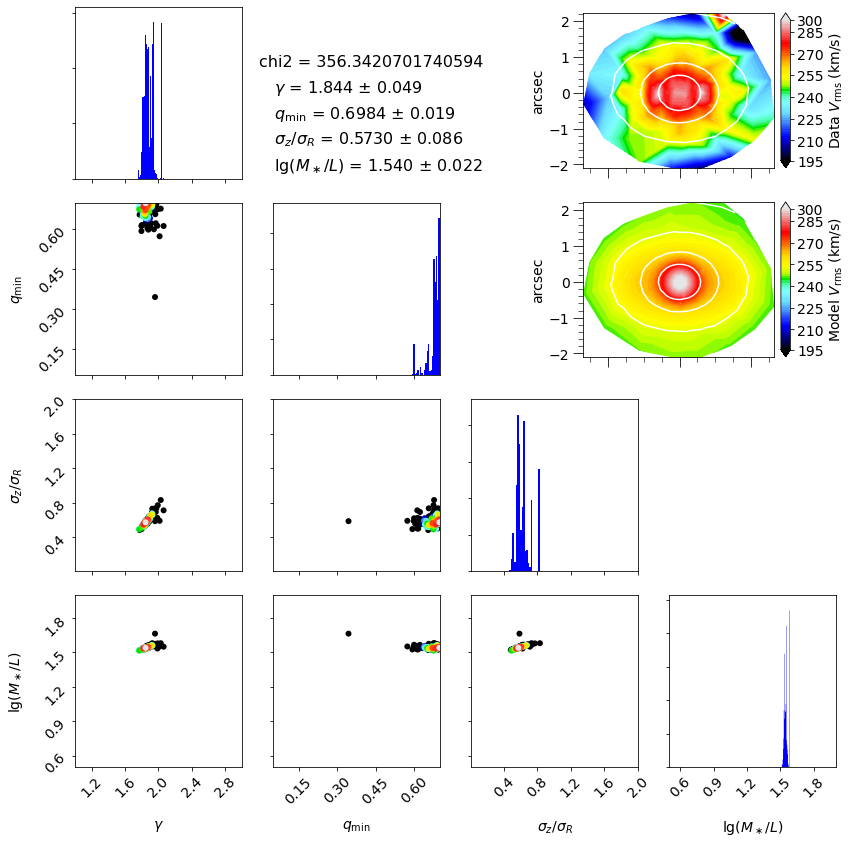

Dynamical mass estimate: 6.32e+11 +/- 1.92e+10
Inclination:  86.26558460893182
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Okay, all done as of 2023_05_26-05_21_56_AM. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.


In [142]:
# set mass model, anisotropy, and alignment
models = ['power_law','nfw']
anis = ['const','OM']
aligns = ['sph', 'cyl']

# set nstep
nstep=5000

print('Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.')
print('...')
print('Please hold...')
print('...')
print('Ah yes, the JAM routine. This one is fun.')
print('...')
print('But where to start?')
print('...')


print('########################################################')
print('########################################################')

for i, obj_name in enumerate([obj_names[1]]):
    
    print(f'Jamming object {obj_name}.')
    print('Brace for jamming.')
    date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")
    print(f'Current date is {date_time}. Hopefully tomorrow will be better.')
    print('########################################################') 
    
    for j, SN in enumerate([vorbin_SN_targets[1]]):
        
        print(f'Designated target is S/N {SN}.')
        
        for k, model in enumerate([models[0]]):
            for l, anisotropy in enumerate([anis[0]]):
                for m, align in enumerate([aligns[0]]):
                    
                    print(f'Commencing JAM routine with model {model}, anisotropy {anisotropy}, and alignment {align}... number of steps {nstep}')
                    print(f'Current date and time is {tick()}')
                    print('JAMMING.')
                    print('########################################################') 
                    
                    if model=='power_law' and anisotropy=='const':
                        p0 = p0_pow_const
                        bounds = bounds_pow_const
                        sigpar = sigpar_pow_const
                        
                    if model=='power_law' and anisotropy=='OM':
                        p0 = p0_pow_om
                        bounds = bounds_pow_om
                        sigpar = sigpar_pow_om
                        
                    if model=='nfw' and anisotropy=='const':
                        p0 = p0_nfw_const
                        bounds = bounds_nfw_const
                        sigpar = sigpar_nfw_const
                        
                    if model=='nfw' and anisotropy=='OM':
                        p0 = p0_nfw_om
                        bounds = bounds_nfw_om
                        sigpar = sigpar_nfw_om

                    space_jam (obj_name, SN, model, anisotropy, align, nstep, p0=p0, bounds=bounds, sigpar=sigpar, date_time=date_time, overwrite=True, run_id=4)

                    print('########################################################') 
                    print("We've been... JAMMED! On to the next?")
                    print('########################################################') 
                    print('########################################################') 

print(f'Okay, all done as of {tick()}. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.')


# 05/26/23 - Tweak to find some good starting guesses.
# Only for spherical models.

In [652]:
# power law constant ani
p0_pow_const = [1.83, 0.5, 0.53, 1.50] # gamma0, q0, ratio0, lg_ml0
bounds_pow_const = [[1, 0.051, 0.01, 0.1], # [[1.5, 0.3, 0.4, 1.3], 
                    [3, 0.8, 1.5, 2.0]]# [2.5, 0.75, 1.0, 1.75]]
sigpar_pow_const = np.array([0.1, 0.1, 0.1, 0.1])  # crude estimate of uncertainties

# power law om ani
p0_pow_om = [1.91, 0.5, 0.393, 1.43] # gamma0, q0, anis_rad0, lg_ml0
bounds_pow_om = [[1, 0.051, 0.1, 0.1],  
                  [3, 0.8, 5.0, 2.0]]
sigpar__om = np.array([0.1, 0.1, 0.1, 0.1])  # crude estimate of uncertainties  

# nfw const ani
p0_nfw_const = [0.4, 0.5, 0.6, 1.3] # f_dm0, q0, ratio0, lg_ml0
bounds_nfw_const = [[0.01, 0.051, 0.01, 0.1], 
                  [0.9, 0.8, 1.5, 2.0]]
sigpar_nfw_const = np.array([0.1, 0.1, 0.1, 0.1])  # crude estimate of uncertainties

# nfw om ani
p0_nfw_om = [0.3, 0.7, 0.393, 1.3] # f_dm0, q0, anis_rad0, lg_ml0
bounds_nfw_om = [[0.01, 0.051, 0.1, 0.1], 
                  [0.9, 0.8, 5.0, 2.0]]
sigpar_nfw_om = np.array([0.1, 0.1, 0.1, 0.1])  # crude estimate of uncertainties    


Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.
...
Please hold...
...
Ah yes, the JAM routine. This one is fun.
...
But where to start?
...
########################################################
########################################################
Jamming object SDSSJ0037-0942.
Brace for jamming.
Current date is 2023_05_26. Hopefully tomorrow will be better.
########################################################
Designated target is S/N 15.
Commencing JAM routine with model power_law, anisotropy const, and alignment sph... number of steps 10000
Current date and time is 2023_05_26-06_10_58_PM
JAMMING.
########################################################

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_05_26_v3_15_power_law_const_sph/

Started AdaMet please wait...
Progress is printed periodically
adamet: 5.0 % done; 1.8 % accepted
adame

/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/sit


Best-fitting parameters and 1sigma errors:
   $\gamma$ = 1.829 +/- 0.028
   $q_{\rm min}$ = 0.6952 +/- 0.0013
   $\sigma_z/\sigma_R$ = 0.5518 +/- 0.026
   $\lg(M_\ast/L)$ = 1.534 +/- 0.0079


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


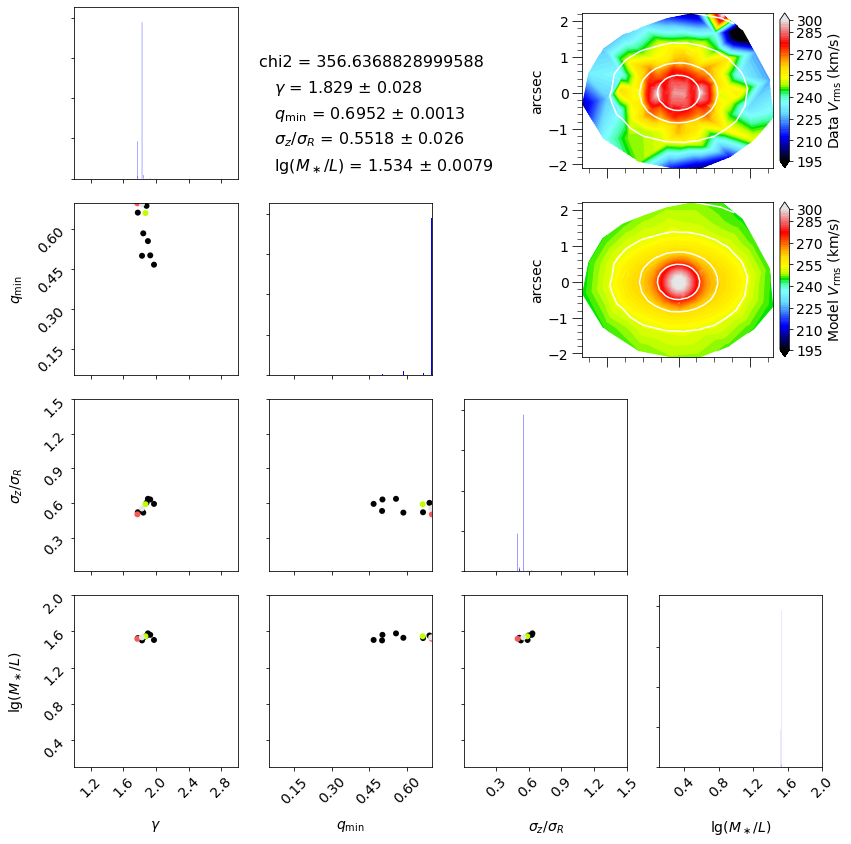

Dynamical mass estimate: 6.23e+11 +/- 1.86e+10
Inclination:  83.44635520404762
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Commencing JAM routine with model power_law, anisotropy OM, and alignment sph... number of steps 10000
Current date and time is 2023_05_27-03_55_38_AM
JAMMING.
########################################################

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_05_26_v3_15_power_law_OM_sph/

Started AdaMet please wait...
Progress is printed periodically
adamet: 5.0 % done; 4.4 % accepted
adamet: 10.0 % done; 3.1 % accepted
adamet: 15.0 % done; 2.9 % accepted
adamet: 20.0 % done; 2.8 % accepted
adamet: 25.0 % done; 2.9 % accepted
adamet: 30.0 % done; 3.1 % accepted
adamet: 35.0 % done; 3.1 % accepted
adamet: 40.0 % done; 3.

/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/sit


Best-fitting parameters and 1sigma errors:
   $\gamma$ = 2.191 +/- 0.011
   $q_{\rm min}$ = 0.6999 +/- 0.0070
   $a_{ani}$ = 0.6911 +/- 0.048
   $\lg(M_\ast/L)$ = 1.451 +/- 0.0059


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


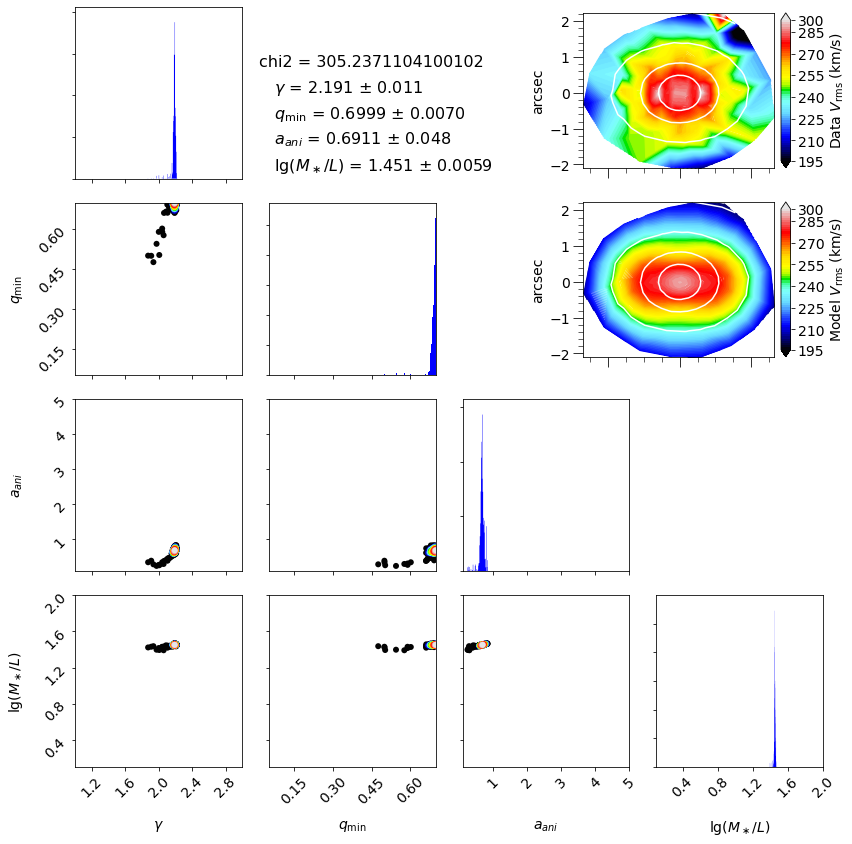

Dynamical mass estimate: 5.16e+11 +/- 1.85e+10
Inclination:  89.02404673000379
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Commencing JAM routine with model nfw, anisotropy const, and alignment sph... number of steps 10000
Current date and time is 2023_05_27-04_21_03_PM
JAMMING.
########################################################

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_05_26_v3_15_nfw_const_sph/

Started AdaMet please wait...
Progress is printed periodically


In [ ]:
# set mass model, anisotropy, and alignment
models = ['power_law','nfw']
anis = ['const','OM']
aligns = ['sph', 'cyl']

# set nstep
nstep=10000

print('Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.')
print('...')
print('Please hold...')
print('...')
print('Ah yes, the JAM routine. This one is fun.')
print('...')
print('But where to start?')
print('...')


print('########################################################')
print('########################################################')

for i, obj_name in enumerate([obj_names[1]]):
    
    print(f'Jamming object {obj_name}.')
    print('Brace for jamming.')
    date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")
    print(f'Current date is {date_time}. Hopefully tomorrow will be better.')
    print('########################################################') 
    
    for j, SN in enumerate([vorbin_SN_targets[1]]):
        
        print(f'Designated target is S/N {SN}.')
        
        for k, model in enumerate(models):
            for l, anisotropy in enumerate(anis):
                for m, align in enumerate([aligns[0]]):
                    
                    print(f'Commencing JAM routine with model {model}, anisotropy {anisotropy}, and alignment {align}... number of steps {nstep}')
                    print(f'Current date and time is {tick()}')
                    print('JAMMING.')
                    print('########################################################') 
                    
                    if model=='power_law' and anisotropy=='const':
                        p0 = p0_pow_const
                        bounds = bounds_pow_const
                        sigpar = sigpar_pow_const
                        
                    if model=='power_law' and anisotropy=='OM':
                        p0 = p0_pow_om
                        bounds = bounds_pow_om
                        sigpar = sigpar_pow_om
                        
                    if model=='nfw' and anisotropy=='const':
                        p0 = p0_nfw_const
                        bounds = bounds_nfw_const
                        sigpar = sigpar_nfw_const
                        
                    if model=='nfw' and anisotropy=='OM':
                        p0 = p0_nfw_om
                        bounds = bounds_nfw_om
                        sigpar = sigpar_nfw_om

                    space_jam (obj_name, SN, model, anisotropy, align, nstep, p0=p0, bounds=bounds, sigpar=sigpar, date_time=date_time, overwrite=False, run_id=3)

                    print('########################################################') 
                    print("We've been... JAMMED! On to the next?")
                    print('########################################################') 
                    print('########################################################') 

print(f'Okay, all done as of {tick()}. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.')


# Take a look at the bestfit from a past fit

In [129]:
import glob

165

Best-fitting parameters and 1sigma errors:
   $\gamma$ = 2.009 +/- 0.31
   $q_{\rm min}$ = 0.5674 +/- 0.18
   $\sigma_z/\sigma_R$ = 0.5486 +/- 0.54
   $\lg(M_\ast/L)$ = 1.531 +/- 0.098


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/sit

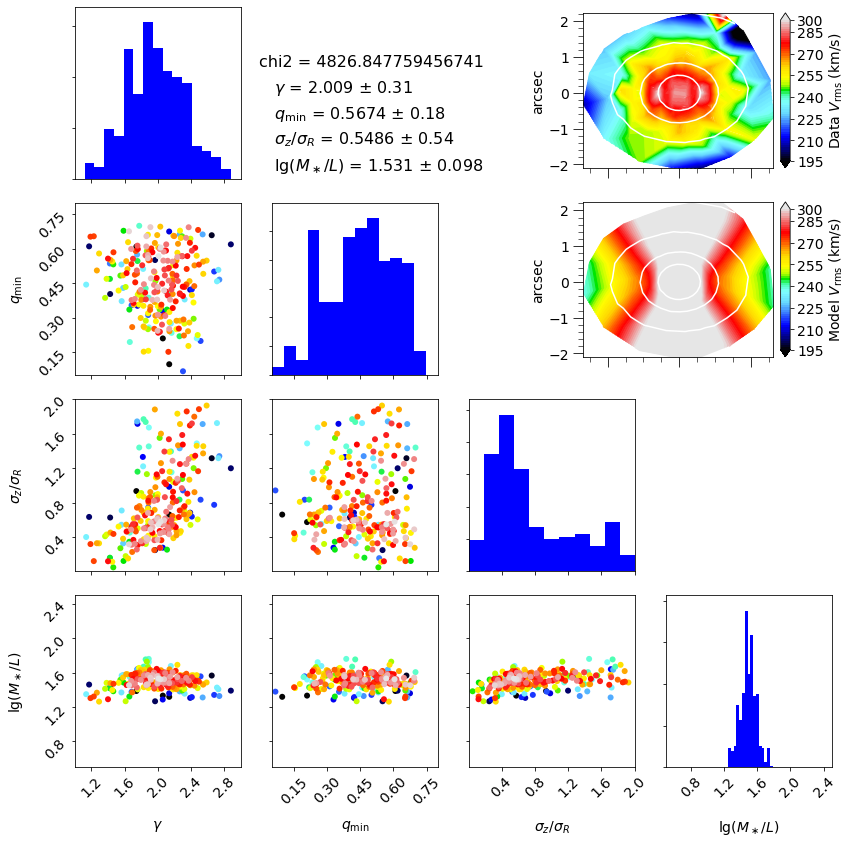

In [138]:
# start with J0037
obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = zs[1]
distance = cosmo.angular_diameter_distance(zlens).value

mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
kin_dir = f'{kinematics_dir}{obj_name}/'
jam_dir = f'{jam_output_dir}{obj_name}/'
# create a directory for JAM outputs
Path(jam_dir).mkdir(parents=True, exist_ok=True)

# start with target sn of 15
SN = '15'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
target_jam_dir = f'{jam_dir}target_sn_{SN}/'
# create a directory for JAM outputs
#Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

# prepare inputs
surf, sigma, qobs, kcwi_sigmapsf, Vrms, dVrms, V, dV, xbin, ybin, reff = prepare_to_jam(obj_name, target_kin_dir, SN)
print(len(xbin))
# get distance from z
slacs_data = np.genfromtxt(f'{tables_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
zlens_column = slacs_data[:,3].astype(float)
slacs_table_name = obj_name[4:]
zlens = zlens_column[slacs_data[:,0]==slacs_table_name]
distance = cosmo.angular_diameter_distance(zlens).value

#############################################################
# JAM Parameters
##############################################################################
##############################################################################

model='power_law'
anisotropy=='const'

if model=='power_law':
    if anisotropy=='const':
        if p0==None:
            # Starting guess, e.g. from a previous least-squares fit
            gamma0 = 2.0             # inner power law slope
            q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
            qbound = np.min(qobs) # upper bound for axis ratio
            ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
            lg_ml0 = 1.5 # change this... my m/l is still weird... 0.8 # np.log10(5)  # M/L from the first fit... I sample the M/L logarithmically
            p0 = [gamma0, q0, ratio0, lg_ml0]
            bounds = [[1, 0.051, 0.01, lg_ml0-1.0], 
                      [3, qbound, 1.0, lg_ml0+1.0]]
            sigpar = np.array([0.1, 0.1, 0.1, 0.1])  # crude estimate of uncertainties
        else:
            # need to input the qbounds from the MGE fit
            q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
            qbound = np.min(qobs) # upper bound for axis ratio
            #p0[1] = q0
            bounds[1][1] = qbound                
        labels = [r'$\gamma$', r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg(M_\ast/L)$"]

jam_prob_func=jam_lnprob
        
goodbins = np.isfinite(xbin)  # Here I fit all bins, it's already masked

# These parameters are passed to JAM
kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qobs,
          'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
          'normpsf': 1., 'rms':Vrms, 'erms':dVrms, 'pixsize': kcwi_scale,
          'goodbins': goodbins, 'plot': False, 'reff':reff, 
              'model':model, 'anisotropy':anisotropy, 'align':align}

date_time='2023_05_23'
model_dir = f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_{SN}/SDSSJ0037-0942_model_{date_time}_{SN}_power_law_const_sph/'

_, _, _, _, _, _ = summary_plot(obj_name, date_time, model_dir, jam_prob_func, 
                             pars=None, lnprob=None, labels=labels, bounds=bounds, 
                             kwargs=kwargs, save=False, load=True)

# I don't know why shit is just not working.

Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.
...
Please hold...
...
Ah yes, the JAM routine. This one is fun.
...
But where to start?
...
########################################################
########################################################
Jamming object SDSSJ0037-0942.
Brace for jamming.
########################################################
Designated target is S/N 15.
Commencing JAM routine with model power_law, anisotropy const, and alignment sph... number of steps 10
Current date and time is 2023_05_25-12_55_45_PM
JAMMING.
########################################################
Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_05_25_v2_15_power_law_const_sph/ will be overwritten.

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_05_25_v2_15_power_law_cons

/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/sit


Best-fitting parameters and 1sigma errors:
   $\gamma$ = 1.970 +/- 0.0
   $q_{\rm min}$ = 0.6300 +/- 0.0
   $\sigma_z/\sigma_R$ = 0.6900 +/- 0.0
   $\lg(M_\ast/L)$ = 1.570 +/- 0.0
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


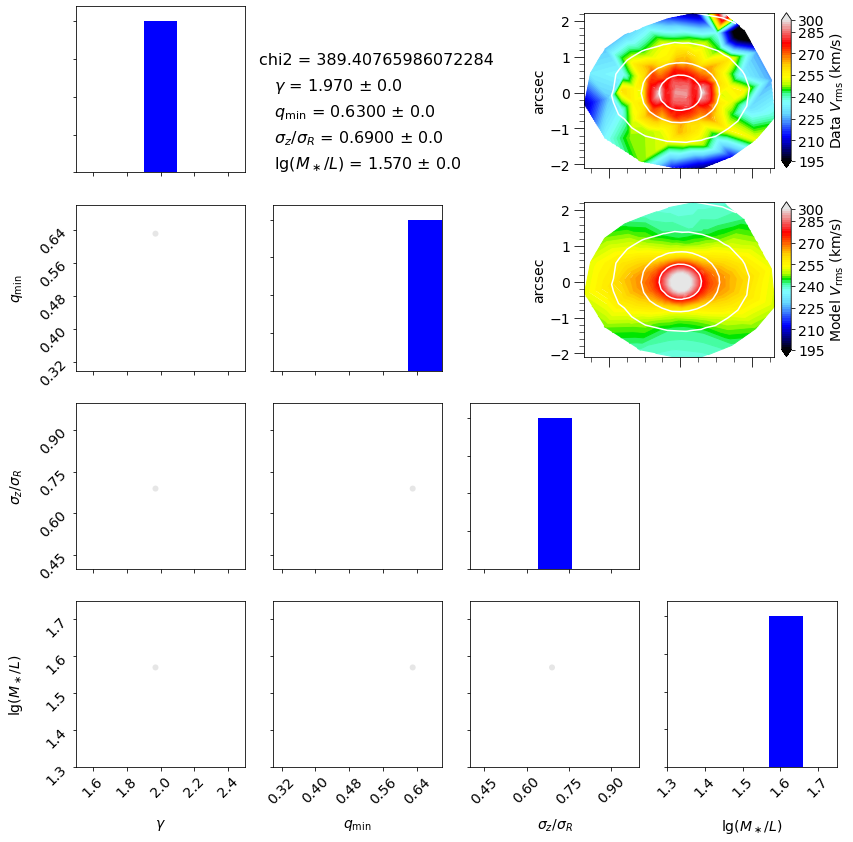

Dynamical mass estimate: 6.78e+11 +/- 1.82e+10
Inclination:  66.86503777776997
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Okay, all done as of 2023_05_25-12_57_12_PM. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.


In [31]:
# set mass model, anisotropy, and alignment
models = ['power_law','nfw']
anis = ['const','OM']
aligns = ['sph', 'cyl']

# set nstep
nstep=10

print('Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.')
print('...')
print('Please hold...')
print('...')
print('Ah yes, the JAM routine. This one is fun.')
print('...')
print('But where to start?')
print('...')

print('########################################################')
print('########################################################')

for i, obj_name in enumerate([obj_names[1]]):
    
    print(f'Jamming object {obj_name}.')
    print('Brace for jamming.')
    print('########################################################') 
    
    for j, SN in enumerate([vorbin_SN_targets[1]]):
        
        print(f'Designated target is S/N {SN}.')
        
        for k, model in enumerate([models[0]]):
            for l, anisotropy in enumerate([anis[0]]):
                for m, align in enumerate([aligns[0]]):
                    
                    print(f'Commencing JAM routine with model {model}, anisotropy {anisotropy}, and alignment {align}... number of steps {nstep}')
                    print(f'Current date and time is {tick()}')
                    print('JAMMING.')
                    print('########################################################') 
                    
                    if model=='power_law' and anisotropy=='const':
                        p0 = p0_pow_const
                        bounds = bounds_pow_const
                        sigpar = sigpar_pow_const
                        
                    if model=='power_law' and anisotropy=='OM':
                        p0 = p0_pow_om
                        bounds = bounds_pow_om
                        sigpar = sigpar_pow_om
                        
                    if model=='nfw' and anisotropy=='const':
                        p0 = p0_nfw_const
                        bounds = bounds_nfw_const
                        sigpar = sigpar_nfw_const
                        
                    if model=='nfw' and anisotropy=='OM':
                        p0 = p0_nfw_om
                        bounds = bounds_nfw_om
                        sigpar = sigpar_nfw_om

                    space_jam (obj_name, SN, model, anisotropy, align, nstep, p0=p0, bounds=bounds, sigpar=sigpar, overwrite=True, run_id=2)

                    print('########################################################') 
                    print("We've been... JAMMED! On to the next?")
                    print('########################################################') 
                    print('########################################################') 

print(f'Okay, all done as of {tick()}. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.')


# Create a way to visualize the differences between these models


Unamming object SDSSJ0037-0942.
Brace for unjamming.
########################################################
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars


Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


(1.4, 1.65)

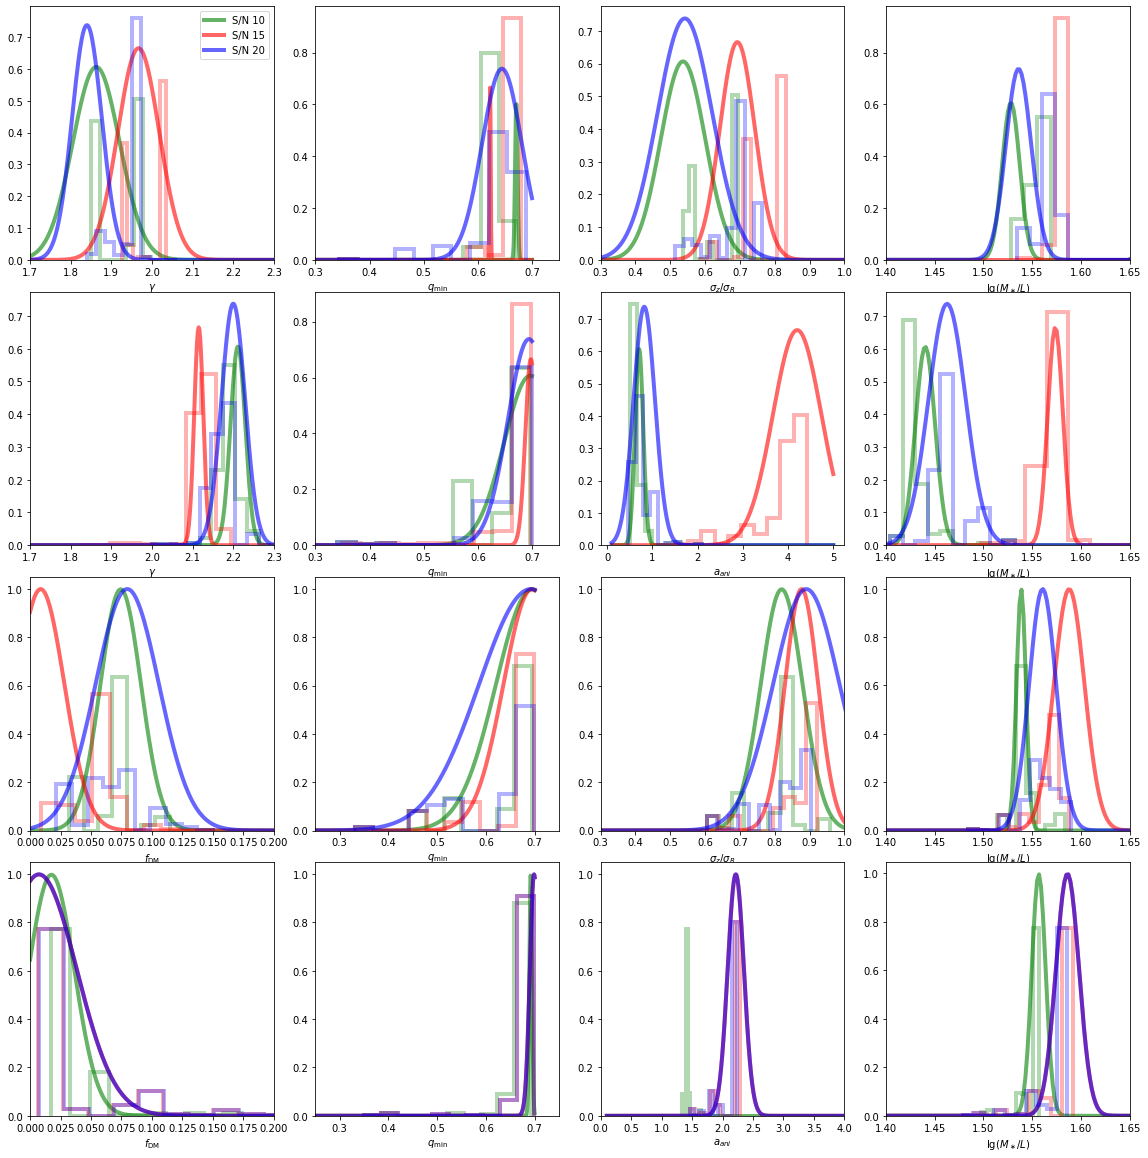

In [76]:
# bring it all in

chi2s=[]

# set mass model, anisotropy, and alignment
models = ['power_law','nfw']
anis = ['const','OM']
aligns = ['sph', 'cyl']

colors = ['green','r','b']
linestyles = ['-','--',':']

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
fig.tight_layout()

switch=0

for i, obj_name in enumerate([obj_names[1]]):
    
    print(f'Unamming object {obj_name}.')
    print('Brace for unjamming.')
    print('########################################################') 
    
    for j, SN in enumerate(vorbin_SN_targets):
        
        for k, model in enumerate(models):
            
            for l, anisotropy in enumerate(anis):
                
                for m, align in enumerate([aligns[0]]):
                    
                    # The date switched halfway through my run...
                    # switched at SN15 nfw
                    if j==1 and k==1:
                        switch=1
                    if switch==0:
                        date_time='2023_05_24'
                        run_id=2
                    elif switch==1:
                        date_time='2023_05_25'
                        run_id=None
                    
                    bestfits, errs, parss, lnprobs, chi2, bounds, rms_model = get_best_param_err (obj_name, SN, model, anisotropy, 
                                                                                                     align, date_time=date_time, run_id=run_id)
                    
                    #if k==1 and l==1:
                        #print(bestfits)
                        #print(errs)
                        #print(rms_model.shape)
                        #print(parss)
                    
                    chi2s.append(chi2)
                    
                    labels = get_labels(model, anisotropy)
                    
                    for n, bestfit in enumerate(bestfits):
                        
                        err = errs[n]
                        pars = parss[:,n] # 4 x 100
                        bound = bounds[:,n]
                        label = labels[n]
                        color = colors[j]
                        linestyle = linestyles[0]

                        xx = np.linspace(bound[0], bound[1], 1000)
                        yy = weighted_gaussian(xx, bestfit, err, chi2/np.max(chi2s))
          
                        # plot best fit parameter
                        axs[2*k+l, n].plot(xx, yy, color=color, linestyle=linestyle, linewidth=4, alpha=0.6, label=f'S/N {SN}')
                        #axs[2*k+l, n].axvline(bestfit)
                        # plot histogram of the parameters
                        axs[2*k+l, n].hist(pars, weights=np.ones_like(pars)/1000, histtype='step', color=color, linewidth=4, alpha=0.3)#, weights=np.exp(lnprobs), histtype='step', color=color)
                        axs[2*k+l, n].set_xlabel(label)
                        #axs[2*k+l, 3].legend(labels=vorbin_SN_targets, loc='right', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5))

h, l = axs[0, 0].get_legend_handles_labels()   
axs[0, 0].legend(handles=h, labels=l, loc='upper right')#, bbox_to_anchor=(0, 1))
axs[0, 0].set_xlim(1.7, 2.3)
axs[1, 0].set_xlim(1.7, 2.3)
axs[2, 0].set_xlim(0, 0.2)
axs[3, 0].set_xlim(0, 0.2)
axs[0, 1].set_xlim(0.3, 0.75)
axs[1, 1].set_xlim(0.3, 0.75)
axs[2, 1].set_xlim(0.25, 0.75)
axs[3, 1].set_xlim(0.25, 0.75)
axs[0, 2].set_xlim(0.3, 1.0)
#axs[1, 2].set_xlim(0, 4)
axs[2, 2].set_xlim(0.3, 1.0)
axs[3, 2].set_xlim(0, 4)
axs[0, 3].set_xlim(1.4, 1.65)
axs[1, 3].set_xlim(1.4, 1.65)
axs[2, 3].set_xlim(1.4, 1.65)
axs[3, 3].set_xlim(1.4, 1.65)

In [123]:
import jampy
help(jampy)

Help on package jampy:

NAME
    jampy

PACKAGE CONTENTS
    examples (package)
    jam_axi_intr
    jam_axi_proj
    legacy (package)
    mge_half_light_isophote
    mge_radial_density
    mge_radial_mass
    mge_vcirc
    quad2d
    quadva

VERSION
    6.3.3

FILE
    /home/shawnknabel/.local/lib/python3.7/site-packages/jampy/__init__.py




In [125]:
import slacs_ani_mass_jam
help(slacs_ani_mass_jam)

Help on module slacs_ani_mass_jam:

NAME
    slacs_ani_mass_jam - 07/07/22 - Auxilliary functions for mass and anisotropy models, and running JAM with different combinations of those, as well as plotting devices.

CLASSES
    builtins.object
        jampy_details
    
    class jampy_details(builtins.object)
     |  jampy_details(surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)
     |  
     |  # class to collect and save all the attributes I need for jampy
     |  
     |  Methods defined here:
     |  
     |  __init__(details, surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
   

__________________
__________________

# BREAK
__________________
__________________